In [1]:
###############################################################################
# The Institute for the Design of Advanced Energy Systems Integrated Platform
# Framework (IDAES IP) was produced under the DOE Institute for the
# Design of Advanced Energy Systems (IDAES).
#
# Copyright (c) 2018-2023 by the software owners: The Regents of the
# University of California, through Lawrence Berkeley National Laboratory,
# National Technology & Engineering Solutions of Sandia, LLC, Carnegie Mellon
# University, West Virginia University Research Corporation, et al.
# All rights reserved.  Please see the files COPYRIGHT.md and LICENSE.md
# for full copyright and license information.
###############################################################################


# Supercritical CO2 Property Surrogate with OMLT Surrogate Object - Training Surrogate (Part 1)

Maintainer: Javal Vyas

Author: Javal Vyas

Updated: 2024-01-24

## 1. Introduction
This notebook illustrates the use of KerasSurrogate API leveraging TensorFlow Keras and OMLT package to produce an ML surrogate based on supercritical CO2 data from simulation using REFPROP package.

There are several reasons to build surrogate models for complex processes, even when higher fidelity models already exist (e.g., reduce model size, improve convergence reliability, replace models with externally compiled code and make them fully-equation oriented).

In this example, we intend to make a surrogate for the physical properties of S-CO2 to be embedded in the property package. This property package will be used to get the physical properties of S-CO2 in the flowsheet simulation. To learn more about property package, see the [IDAES-PSE](https://github.com/IDAES/idaes-pse) Github Page or IDAES [Read-the-docs](https://idaes-pse.readthedocs.io/en/latest/). 

### 1.1 Need for ML Surrogates

The properties predicted by the surrogate are enthalpy and entropy of the S-CO2 based on the 
pressure and temperature of the system. The analytical equation of getting the enthalpy and entropy from pressure and temperature are in the differential form and would make the problem a DAE system. To counter this problem and keep the problem algebraic, we will use the ML surrogates and relate enthalpy and entropy with the pressure and temperature as an algebraic equation.

### 1.2 Supercritical CO2 cycle process

The following flowsheet will be used to optimize the design for the cooling of the fusion reactor using supercritical CO2 cycle. We shall focus on training the surrogate for this notebook and move to constructing the flowsheet and the properties package in the subsequent notebooks. The take away from this flowsheet is that, 3 variables can be measured in any given unit which are flow, pressure and temperature and other properties can be calculated using them. Thus, surrogate should have pressure and temperature as the inputs.

In this example, we will train a tanh model from our data and then demonstrate that we can solve an optimization problem with that surrogate model. 

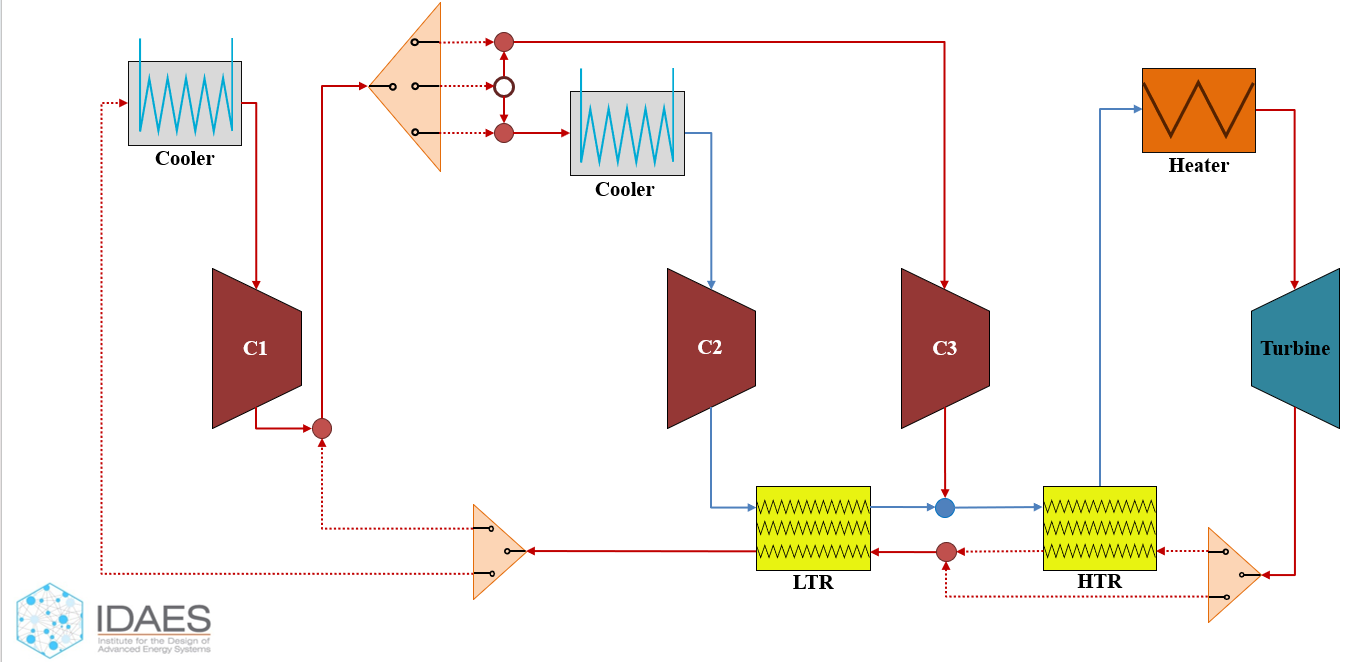

In [2]:
from IPython.display import Image
from pathlib import Path


def datafile_path(name):
    return Path("..") / name


Image(datafile_path("CO2_flowsheet.png"))

## 2. Training and Validating Surrogate

First, let's import the required Python and IDAES modules:

In [3]:
# Import statements
import os
import numpy as np
import pandas as pd
import random as rn
import tensorflow as tf
import tensorflow.keras as keras

# Import IDAES libraries
from idaes.core.surrogate.sampling.data_utils import split_training_validation
from idaes.core.surrogate.sampling.scaling import OffsetScaler
from idaes.core.surrogate.keras_surrogate import KerasSurrogate
from idaes.core.surrogate.plotting.sm_plotter import (
    surrogate_scatter2D,
    surrogate_parity,
    surrogate_residual,
)

# fix environment variables to ensure consist neural network training
os.environ["PYTHONHASHSEED"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
np.random.seed(46)
rn.seed(1342)
tf.random.set_seed(62)

expression symbols from pyomo.core.expr  (deprecated in 6.6.2) (called from
<frozen importlib._bootstrap>:241)


### 2.1 Importing Training and Validation Datasets

In this section, we read the dataset from the CSV file located in this directory. 500 data points were simulated for S-CO2 physical properties using REFPROP package. This example is trained on the entire dataset because neural  network can overfit on smaller dataset. The data is separated using an 80/20 split into training and validation data using the IDAES split_training_validation() method.

We rename the column headers because they contained ".", which may cause errors while reading the column names in subsequent code, thus as a good practice we change them to the variable names to be used in the property package. Further, the input variables are **pressure**, **temperature** , while the output variables are **enth_mol**, **entr_mol**, hence we create two new dataframes for the input and output variables. 

In [4]:
# Import training data
np.set_printoptions(precision=6, suppress=True)

csv_data = pd.read_csv(datafile_path("500_Points_DataSet.csv"))
csv_data.columns.values[0:6] =["pressure", "temperature","enth_mol","entr_mol","CO2_enthalpy","CO2_entropy"]
data = csv_data.sample(n=500)

# Creating input_data and output_data from data
input_data = data.iloc[:, :2]
output_data = data.iloc[:,2:4]

# Define labels, and split training and validation data
input_labels = input_data.columns
output_labels =  output_data.columns 

n_data = data[input_labels[0]].size
data_training, data_validation = split_training_validation(
    data, 0.8, seed=n_data
)

### 2.2 Training Surrogate with TensorFlow Keras
TensorFlow Keras provides an interface to pass regression settings, build neural networks and train surrogate models. Keras enables the usage of two API formats: Sequential and Functional. While the Functional API offers more versatility, including multiple input and output layers in a single neural network, the Sequential API is more stable and user-friendly. Further, the Sequential API integrates cleanly with existing IDAES surrogate tools and will be utilized in this example.

In the code below, we build the neural network structure based on our training data structure and desired regression settings. Offline, neural network models were trained for the list of settings below, and the options bolded and italicized were determined to have the minimum mean squared error for the dataset:

* Activation function: sigmoid, **tanh**
* Optimizer: **Adam**
* Number of hidden layers: 3, **4**, 5, 6
* Number of neurons per layer: **20**, 40, 60

Important thing to note here is that we do not use ReLU activation function for the training as the flowsheet we intend to solve with this surrogate model is a NLP problem and using ReLU activation function will make it an MINLP. Another thing to note here is the network is smaller (4,20) in order to avoid overfitting.  

Typically, Sequential Keras models are built vertically; the dataset is scaled and normalized. The network is defined for the input layer, hidden layers, and output layer for the passed activation functions and network/layer sizes. Then, the model is compiled using the passed optimizer and trained using a desired number of epochs. Keras internally validates while training and updates each epoch's model weight (coefficient) values.

Finally, after training the model, we save the results and model expressions to a folder that contains a serialized JSON file. Serializing the model in this fashion enables importing a previously trained set of surrogate models into external flowsheets. This feature will be used later.

Epoch 1/250
13/13 - 3s - loss: 0.4963 - mae: 0.5592 - mse: 0.4963 - val_loss: 0.1685 - val_mae: 0.3349 - val_mse: 0.1685 - 3s/epoch - 249ms/step
Epoch 2/250
13/13 - 0s - loss: 0.1216 - mae: 0.2839 - mse: 0.1216 - val_loss: 0.0809 - val_mae: 0.2245 - val_mse: 0.0809 - 237ms/epoch - 18ms/step
Epoch 3/250
13/13 - 0s - loss: 0.0665 - mae: 0.2043 - mse: 0.0665 - val_loss: 0.0359 - val_mae: 0.1503 - val_mse: 0.0359 - 262ms/epoch - 20ms/step
Epoch 4/250
13/13 - 0s - loss: 0.0294 - mae: 0.1329 - mse: 0.0294 - val_loss: 0.0221 - val_mae: 0.1119 - val_mse: 0.0221 - 283ms/epoch - 22ms/step
Epoch 5/250
13/13 - 0s - loss: 0.0170 - mae: 0.0964 - mse: 0.0170 - val_loss: 0.0115 - val_mae: 0.0792 - val_mse: 0.0115 - 351ms/epoch - 27ms/step
Epoch 6/250
13/13 - 0s - loss: 0.0097 - mae: 0.0734 - mse: 0.0097 - val_loss: 0.0067 - val_mae: 0.0636 - val_mse: 0.0067 - 364ms/epoch - 28ms/step
Epoch 7/250
13/13 - 0s - loss: 0.0061 - mae: 0.0610 - mse: 0.0061 - val_loss: 0.0048 - val_mae: 0.0550 - val_mse: 0.0048

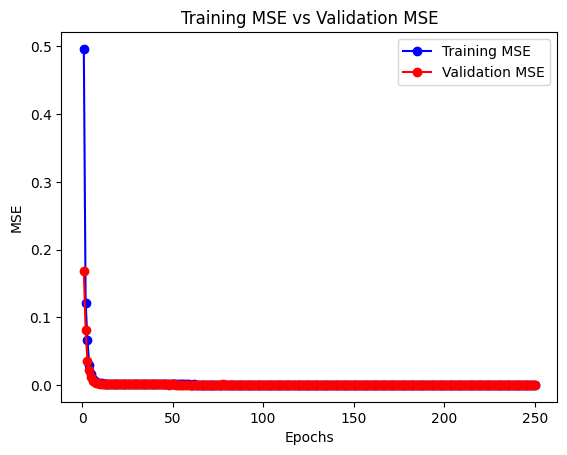

In [5]:
import matplotlib.pyplot as plt

# selected settings for regression (best fit from options above)
activation, optimizer, n_hidden_layers, n_nodes_per_layer = "tanh", "Adam", 4, 20
loss, metrics = "mse", ["mae", "mse"]

# Create data objects for training using scalar normalization
n_inputs = len(input_labels)
n_outputs = len(output_labels)
x = input_data
y = output_data

input_scaler = None
output_scaler = None
input_scaler = OffsetScaler.create_normalizing_scaler(x)
output_scaler = OffsetScaler.create_normalizing_scaler(y)
x = input_scaler.scale(x)
y = output_scaler.scale(y)
x = x.to_numpy()
y = y.to_numpy()

# Create Keras Sequential object and build neural network
model = tf.keras.Sequential()
model.add(
    tf.keras.layers.Dense(
        units=n_nodes_per_layer, input_dim=n_inputs, activation=activation
    )
)
for i in range(1, n_hidden_layers):
    model.add(tf.keras.layers.Dense(units=n_nodes_per_layer, activation=activation))
model.add(tf.keras.layers.Dense(units=n_outputs,activation=keras.activations.linear))

# Train surrogate (calls optimizer on neural network and solves for weights)
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
mcp_save = tf.keras.callbacks.ModelCheckpoint(
    ".mdl_co2.keras", save_best_only=True, monitor="val_loss", mode="min"
)
history = model.fit(x=x, y=y, validation_split=0.2, verbose=2, epochs=250, callbacks=[mcp_save])

# Get the training and validation MSE from the history
train_mse = history.history['mse']
val_mse = history.history['val_mse']

# Generate a plot of training MSE vs validation MSE
epochs = range(1, len(train_mse) + 1)
plt.plot(epochs, train_mse, 'bo-', label='Training MSE')
plt.plot(epochs, val_mse, 'ro-', label='Validation MSE')
plt.title('Training MSE vs Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [6]:
# Adding input bounds and variables along with scalers and output variable to kerasSurrogate
xmin, xmax = [7,306], [40,1000]
input_bounds = {input_labels[i]: (xmin[i], xmax[i]) for i in range(len(input_labels))}

keras_surrogate = KerasSurrogate(
    model,
    input_labels=list(input_labels),
    output_labels=list(output_labels),
    input_bounds=input_bounds,
    input_scaler=input_scaler,
    output_scaler=output_scaler,
)
keras_surrogate.save_to_folder(keras_folder_name="sco2_keras_surr", keras_model_name="sco2_keras_model")

INFO:tensorflow:Assets written to: keras_surrogate\assets


### 2.3 Visualizing Surrogates

Now that the surrogate models have been trained, the models can be visualized through scatter, parity and residual plots to confirm their validity in the chosen domain. The training data will be visualized first to confirm the surrogates are fit the data, and then the validation data will be visualized to confirm the surrogates accurately predict new output values.

13/13 [==============================] - 1s 3ms/step


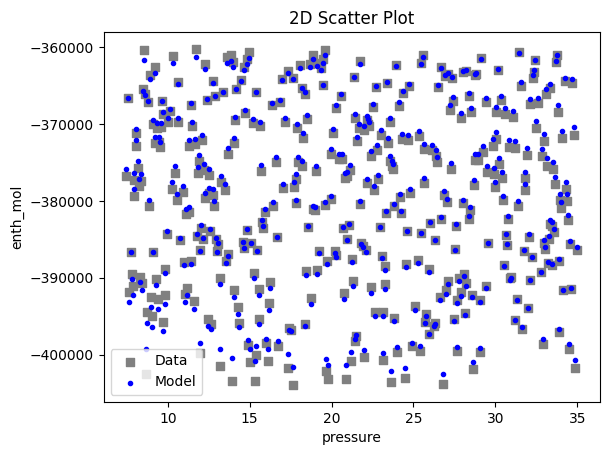

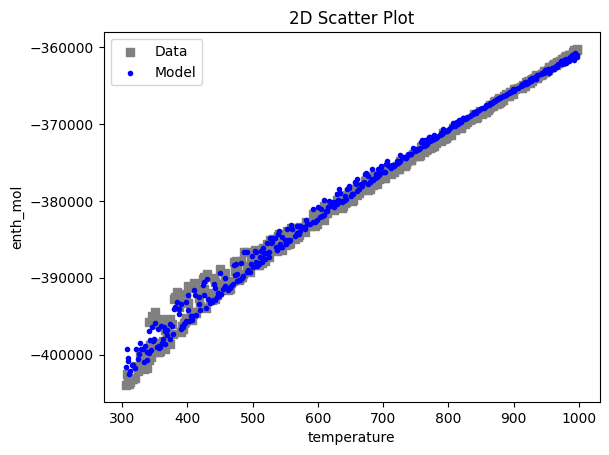

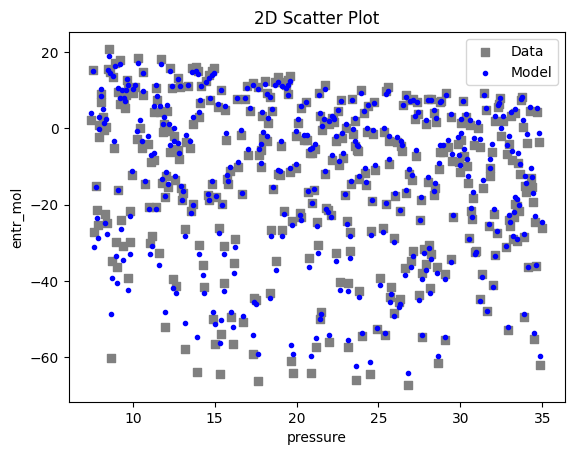

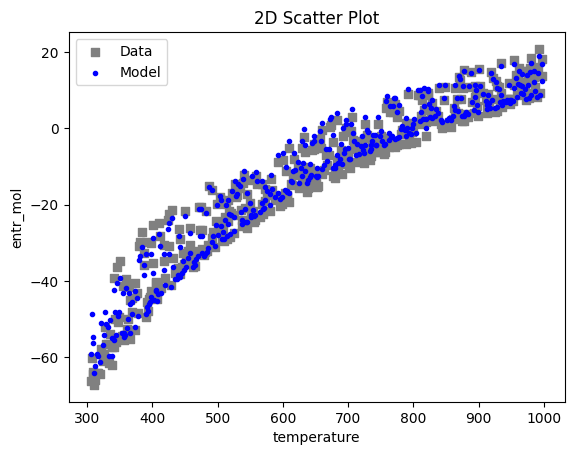

13/13 [==============================] - 0s 3ms/step


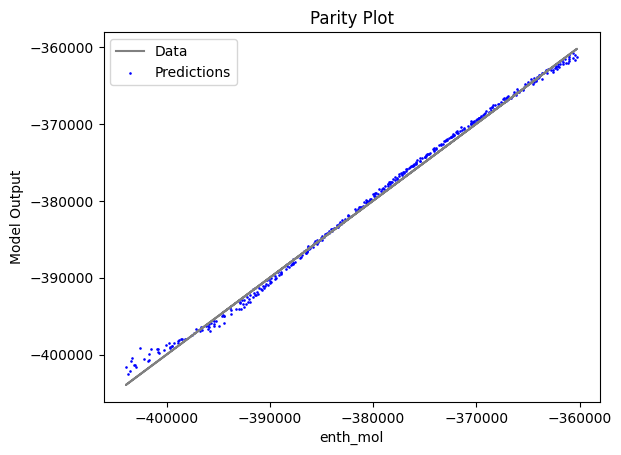

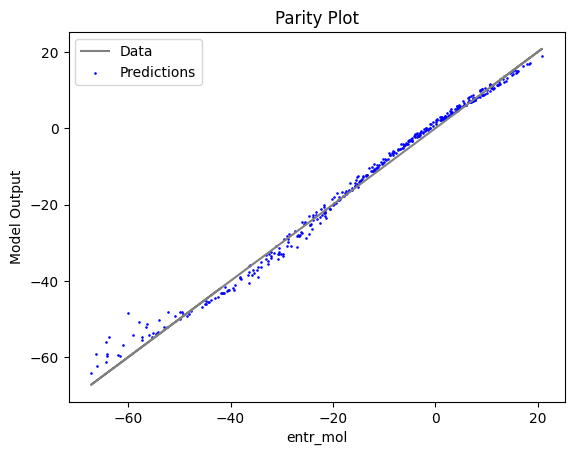

13/13 [==============================] - 0s 4ms/step


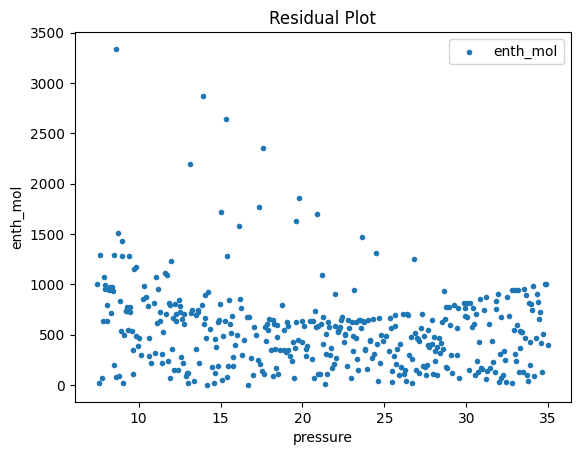

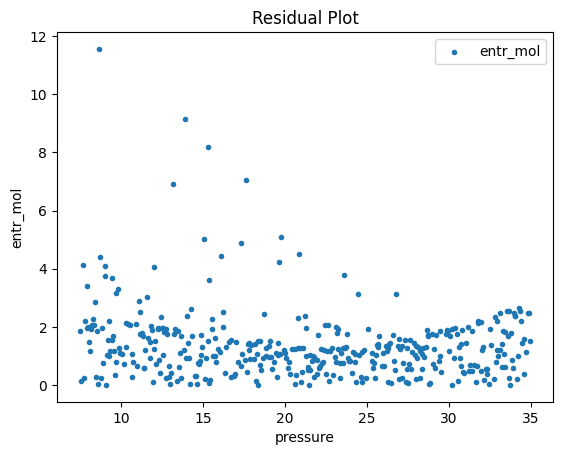

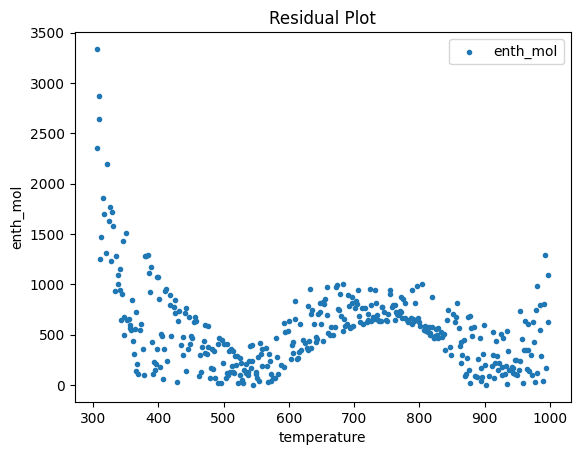

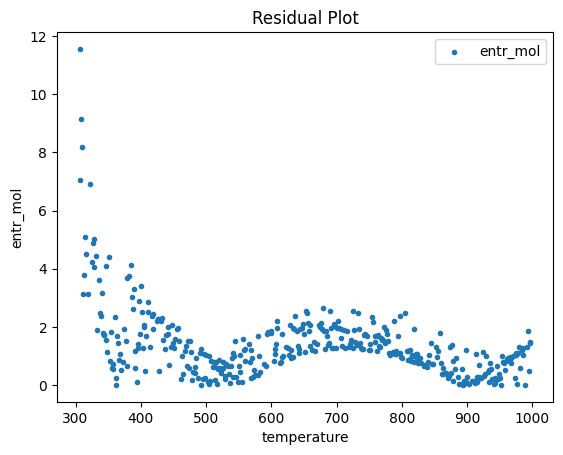

In [7]:
surrogate_scatter2D(keras_surrogate, data_training)
surrogate_parity(keras_surrogate, data_training)
surrogate_residual(keras_surrogate, data_training)

### 2.4 Model Validation

We check the fit on the validation set to see if the surrogate is fitting well. This step can be used to check for overfitting on the training set.

4/4 [==============================] - 0s 5ms/step


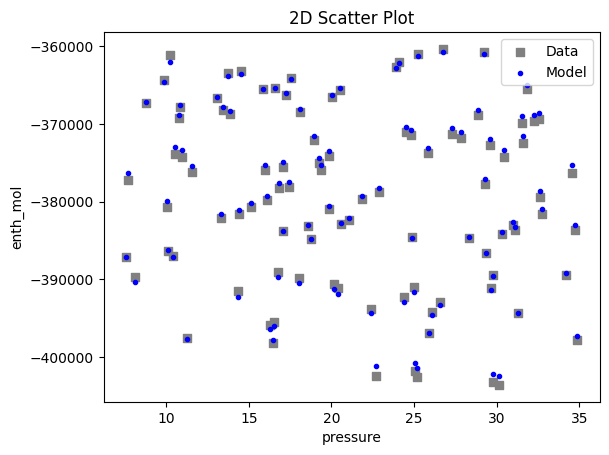

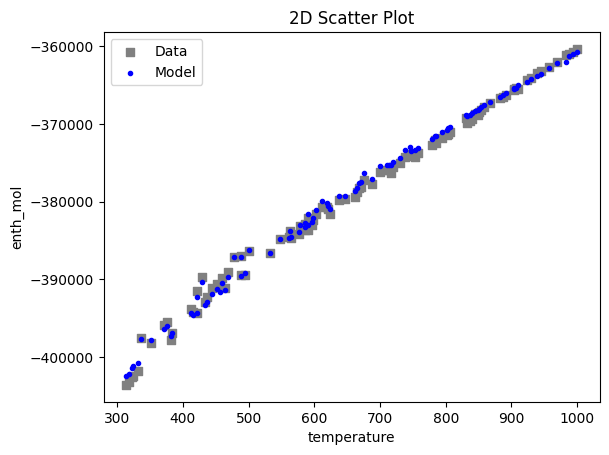

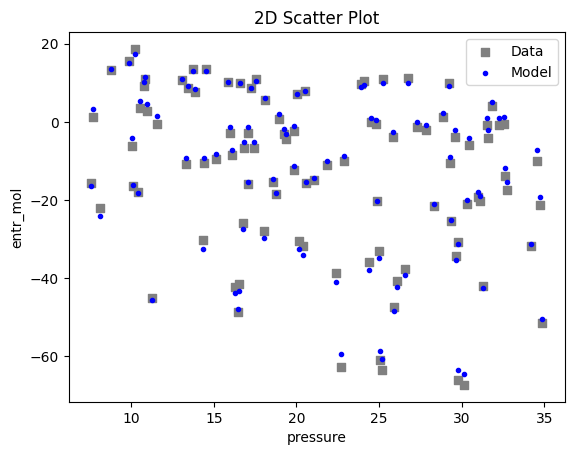

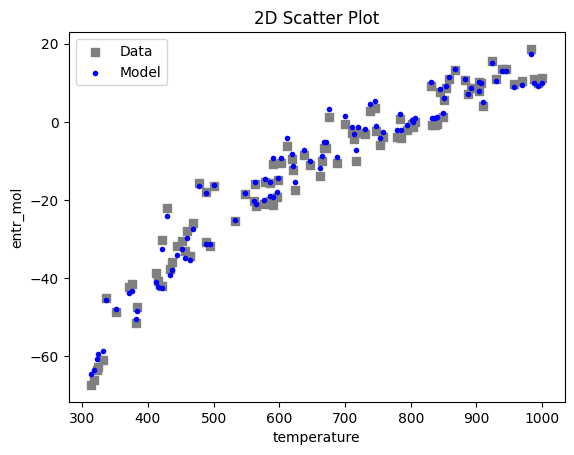

4/4 [==============================] - 0s 4ms/step


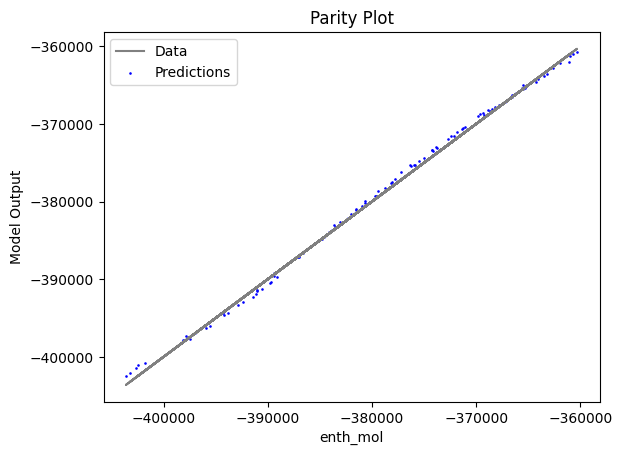

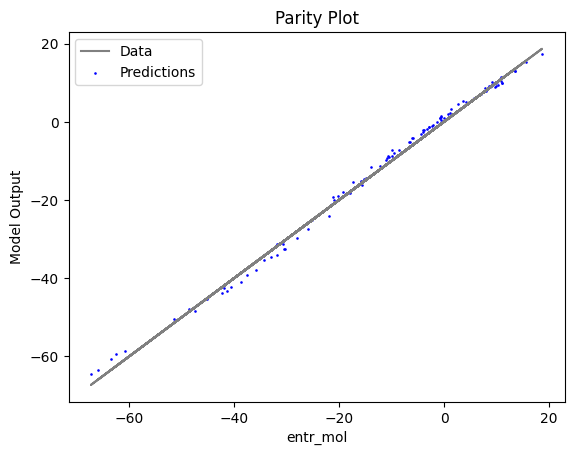

4/4 [==============================] - 0s 5ms/step


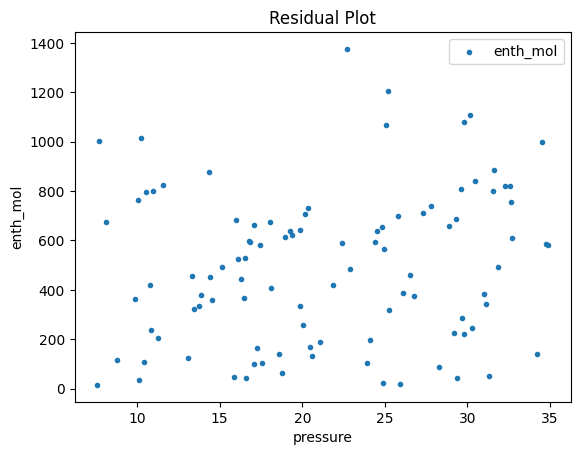

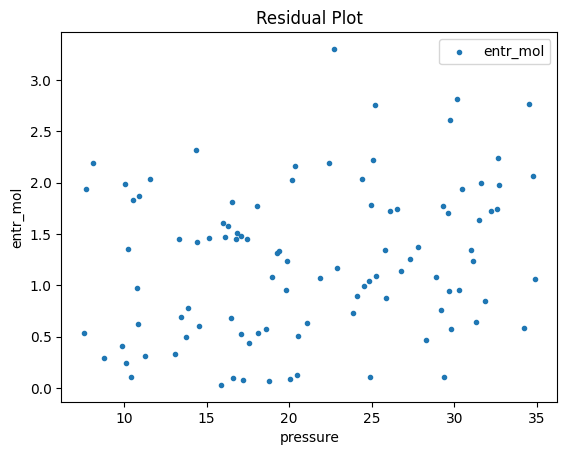

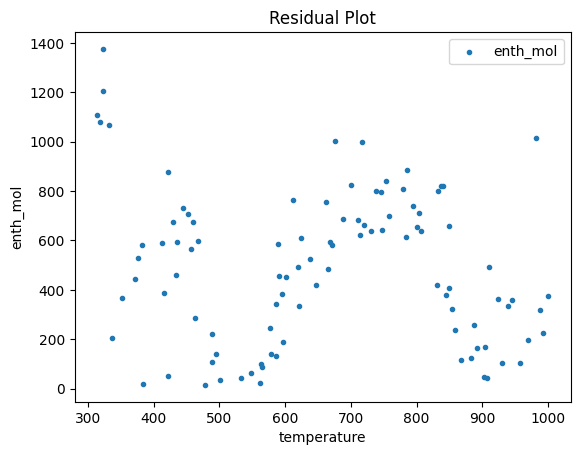

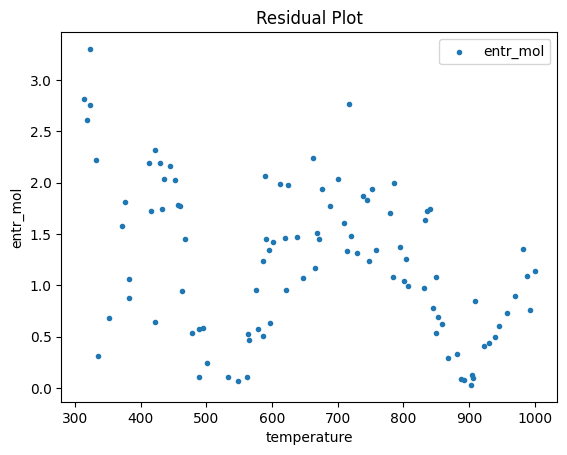

In [8]:
# visualize with IDAES surrogate plotting tools
surrogate_scatter2D(keras_surrogate, data_validation)
surrogate_parity(keras_surrogate, data_validation)
surrogate_residual(keras_surrogate, data_validation)

Now, the surrogate is trained and validated, we shall embed it in the property package, which is demonstrated in the [surrogate_embedding_doc.md](./surrogate_embedding_doc.md) file.